In [1]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit

In [2]:
pdb = app.PDBFile('butane.pdb')
forcefield = app.ForceField('butane.gaff2.xml')

In [3]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.384565075698099 kJ/mol
Potential energy after minimization is 5.297922227327014 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(298.0*unit.kelvin)
simulation.step(5000)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,30.29011840387216,184.26011183015984
500,44.084666651464104,124.46468355391393
750,37.42739267238698,309.71316486466174
1000,39.738572255464284,507.266313518318
1250,32.388590475798466,280.71554523644994
1500,51.68236912737291,294.88649741578547
1750,51.08985545770625,191.62762832771546
2000,54.807733305564824,300.6989050369633
2250,45.053649718853535,282.79991178857296
2500,32.46776037992281,226.19370546718167
2750,34.29472352119372,319.9634251286482
3000,31.460287674042455,188.12622615773128
3250,36.507452854633364,313.6429995963956
3500,39.35390159191742,274.5564544406902
3750,34.62365563798516,197.11821700926237
4000,45.763302328356225,254.03483691842433
4250,43.64343382521417,264.4485557441998
4500,41.88499687422803,335.99684253892644
4750,30.42730173706166,299.7998041308005
5000,43.018864488032406,269.74584065621997


In [6]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7*2 steps - 20*2 = 40 ns
simulation.step(20000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,41.71572287479586,377.0392756701764,0
500000,999.9999999901769,42.08439056463014,494.08592538641295,1.06e+04
750000,1499.9999999783536,33.93865127772576,334.87324935213076,1.11e+04
1000000,1999.9999999665301,33.16292650518016,221.7791848075571,1.12e+04
1250000,2499.9999999547067,37.06356369904606,257.4576789531081,1.15e+04
1500000,2999.9999999428833,53.62499693365875,194.63690876939913,1.16e+04
1750000,3499.99999993106,59.83585891445989,339.19996490405265,1.17e+04
2000000,3999.9999999192364,54.134316482370494,323.81046432564995,1.17e+04
2250000,4499.9999999992715,43.33656601539507,308.3662008925654,1.17e+04
2500000,5000.000000101135,40.01272063734109,292.44252720129725,1.14e+04
2750000,5500.000000202998,45.76178212777634,360.27662319693974,1.04e+04
3000000,6000.000000304862,41.13958089174441,449.31685381794097,9.74e+03
3250000,6500.000000406725,40.075577782

In [7]:
import mdtraj as md

traj = md.load('butane_sim.dcd', top='butane.pdb')

In [8]:
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=199999)

In [9]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,LIG,0,
1,2,C2,C,1,LIG,0,
2,3,C3,C,1,LIG,0,
3,4,C4,C,1,LIG,0,
4,5,H11,H,1,LIG,0,
5,6,H12,H,1,LIG,0,
6,7,H13,H,1,LIG,0,
7,8,H21,H,1,LIG,0,
8,9,H22,H,1,LIG,0,
9,10,H31,H,1,LIG,0,


In [10]:
torsion_indices = [4, 0, 1, 7] # atoms to define the bond length
torsion = md.compute_dihedrals(traj, [torsion_indices])

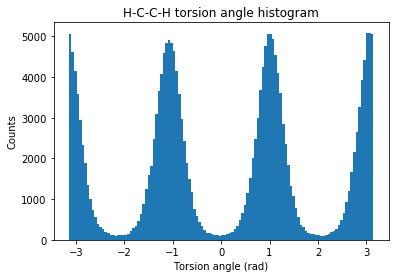

In [12]:
import matplotlib.pyplot as plt

phicounts, binedges, otherstuff = plt.hist(torsion, bins=120)
plt.title('H-C-C-H torsion angle histogram')
plt.xlabel('Torsion angle (rad)')
plt.ylabel('Counts')
plt.show()

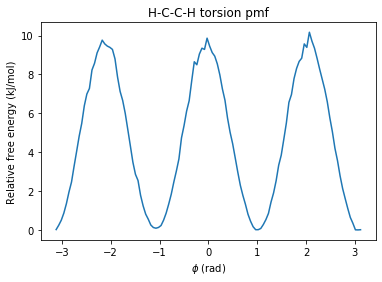

In [15]:
import numpy as np 
import statsmodels.api as sm

kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

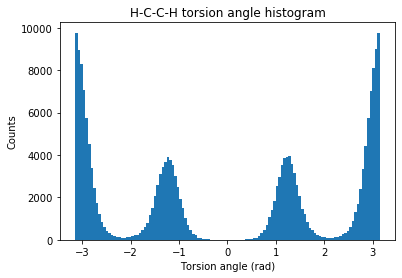

In [16]:
# Analyze the C-C-C-C torsion angle and compute the PMF.
CCCC_indices = [0, 1, 2, 3] # atoms to define the bond length
CCCC_torsion = md.compute_dihedrals(traj, [CCCC_indices])

phicounts, binedges, otherstuff = plt.hist(CCCC_torsion, bins=120)
plt.title('C-C-C-C torsion angle histogram')
plt.xlabel('Torsion angle (rad)')
plt.ylabel('Counts')
plt.show()

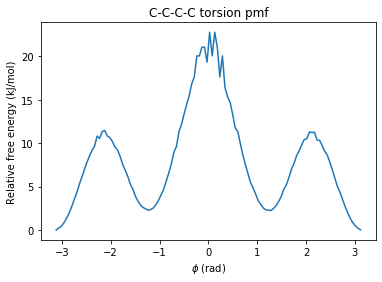

In [17]:
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C-C torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

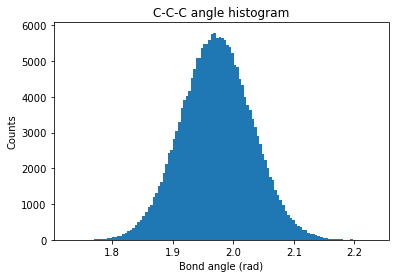

In [19]:
# Analyze the C-C-C bond angle (use C1-C2-C3) and compute the PMF.
CCC_indices = [0, 1, 2] # atoms to define the bond length
CCCC_angle = md.compute_angles(traj, [CCC_indices])

anglecounts, binedges, otherstuff = plt.hist(CCCC_angle, bins=120)
plt.title('C-C-C angle histogram')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

/dartfs-hpc/rc/home/y/f0047qy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


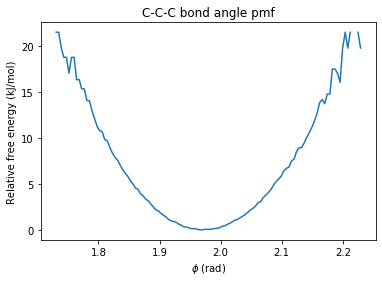

In [21]:
anglecounts[anglecounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C bond angle pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

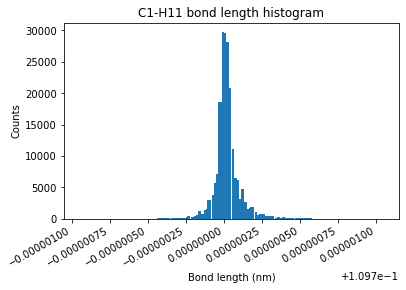

In [32]:
# Make only a histogram of one of the C-H bond lengths. Pick C1 - H11.
bond_indices = [0, 4] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C1-H11 bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.gcf().autofmt_xdate()
plt.show()

### The distribution is centered around 1.097 A, where C-H bond length is about 1.09A. But the distribution is not like a harmonic potential.